## Determining the concrete strength in terms of given features

In [32]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [58]:
import pandas as pd
import numpy as np
from collections import OrderedDict
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [34]:
df=pd.read_excel("Capstone project.xlsx")
df.head()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,141.3,212.0,0.0,203.5,0.0,971.8,748.5,28,29.89
1,168.9,42.2,124.3,158.3,10.8,1080.8,796.2,14,23.51
2,250.0,0.0,95.7,187.4,5.5,956.9,861.2,28,29.22
3,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.85
4,154.8,183.4,0.0,193.3,9.1,1047.4,696.7,28,18.29


In [35]:
df.shape

(1030, 9)

In [36]:
def des_stat(new_df):
    result=[]
    for col in list(new_df.columns):
        stat=OrderedDict({'feature_name':col,'count':new_df[col].count(),'minimum':new_df[col].min(),'Q1':new_df[col].quantile(0.25),
                                'mean':new_df[col].mean(),'median':new_df[col].median(),'Q3':new_df[col].quantile(0.75),'Maximum':new_df[col].max(),
                              'variance':round(new_df[col].var(),2),'sd':round(new_df[col].std(),2),'kurtosis':round(new_df[col].kurt(),2),'skewness':round(new_df[col].skew(),2)})
        result.append(stat)
        if new_df[col].skew()<-1:
            sk_label='Highly negatively skewed'
        elif -1 <=new_df[col].skew()<-0.5:
            sk_label='moderately negatively skewed'
        elif -0.5 <=new_df[col].skew()<0:
            sk_label='fairly negatively skewed(normal distribution)'
        elif 0<=new_df[col].skew()<0.5:
            sk_label='fairly positive skewed(normal distribution)'
        elif 0.5<=new_df[col].skew()<1:
            sk_label='moderately positively skewed'
        elif new_df[col].skew()>1:
            sk_label='highly positively skewed'
        else:
            sk_label='error'
        stat.update({'skewness_status':sk_label})
    result=pd.DataFrame(result)
    return(result)

In [37]:
des_stat(df)

,feature_name,count,minimum,Q1,mean,median,Q3,Maximum,variance,sd,kurtosis,skewness,skewness_status
0,cement,1030,102.00,192.375,281.167864,272.900,350.000,540.0,10921.58,104.51,-0.52,0.51,moderately positively skewed
1,slag,1030,0.00,0.000,73.895825,22.000,142.950,359.4,7444.12,86.28,-0.51,0.80,moderately positively skewed
2,ash,1030,0.00,0.000,54.188350,0.000,118.300,200.1,4095.62,64.00,-1.33,0.54,moderately positively skewed
3,water,1030,121.80,164.900,181.567282,185.000,192.000,247.0,456.00,21.35,0.12,0.07,fairly positive skewed(normal distribution)
4,superplastic,1030,0.00,0.000,6.204660,6.400,10.200,32.2,35.69,5.97,1.41,0.91,moderately positively skewed
5,coarseagg,1030,801.00,932.000,972.918932,968.000,1029.400,1145.0,6045.68,77.75,-0.60,-0.04,fairly negatively skewed(normal distribution)
6,fineagg,1030,594.00,730.950,773.580485,779.500,824.000,992.6,6428.19,80.18,-0.10,-0.25,fairly negatively skewed(normal distribution)
7,age,1030,1.00,7.000,45.662136,28.000,56.000,365.0,3990.44,63.17,12.17,3.27,highly positively skewed
8,strength,1030,2.33,23.710,35.817961,34.445,46.135,82.6,279.08,16.71,-0.31,0.42,fairly positive skewed(normal distribution)


### Descriptive stats analysis

1. age is highly positively skewed 
2. this is yearly data as the age column has highest of value 365
3. ash has values denser after the second quartile
4. slag,ash and superplastic have values denser after the first quartile
5. most of the features have outliers that needs outlier treatment 

### Outlier treatment function

In [38]:
def replace_outlier(df,col,method='quartile',strategy='median'): # as median does not get influenced by the outliers...so median is the best rep as strategy
    
    col_data=df[col]
    
    if method=='quartile':
        
        q1=df[col].quantile(0.25)
        q2=df[col].quantile(0.5)
        q3=df[col].quantile(0.75)
        iqr=q3-q1
        lower_limit=q1-1.5*iqr          
        upper_limit=q3+1.5*iqr
        
    elif method=='std_dev':
        
        col_mean=df[col].mean()
        col_std_dev=df[col].std()
        lwr_limit=col_mean-2*col_std_dev
        upr_limit=col_mean+2*col_std_dev
    
    
    outliers=df.loc[(col_data < lower_limit)|(col_data > upper_limit),col]
    outliers_density=len(outliers)/len(df)
    print(outliers_density)
    
    if strategy=='median':
        
        df.loc[(col_data < lower_limit)|(col_data > upper_limit),col]=q2
        
    elif strategy=='mean':
        
        df.loc[(col_data < lower_limit)|(col_data > upper_limit),col]=col_mean
    
    return df

### Plotting ODT (Outlier Detection Plots)

In ODT plot we have three types of plots. 1-Boxplot 2-Histogram with outliers 3-Histogram without outliers

In [39]:
def odt_plots(df,col):
    
    f,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(20,20))
    
    # Boxplot fot descriptive stats
    
    sns.boxplot(df[col],ax=ax1,color='red')
    ax1.set_title(col+ ' ' + 'Boxplot')
    ax1.set_xlabel('Boxplot')
    ax1.set_ylabel('value')
    
    # Ploting histogram with outliers
    
    sns.distplot(df[col],ax=ax2,color='blue')
    ax2.set_title(col+ ' ' + 'distplot with outliers')
    ax2.set_xlabel('Histogram')
    ax2.set_ylabel('Values')
    
    # Ploting histogram after treating outliers
    
    y=replace_outlier(df,col)
    
    sns.distplot(y[col],ax=ax3,color='green')
    ax3.set_title(col + ' ' + 'Histogram without outliers')
    ax3.set_xlabel('Histogram')
    ax3.set_ylabel('Values')

0.0
0.001941747572815534
0.0
0.008737864077669903
0.009708737864077669
0.0
0.0048543689320388345
0.05728155339805825
0.003883495145631068


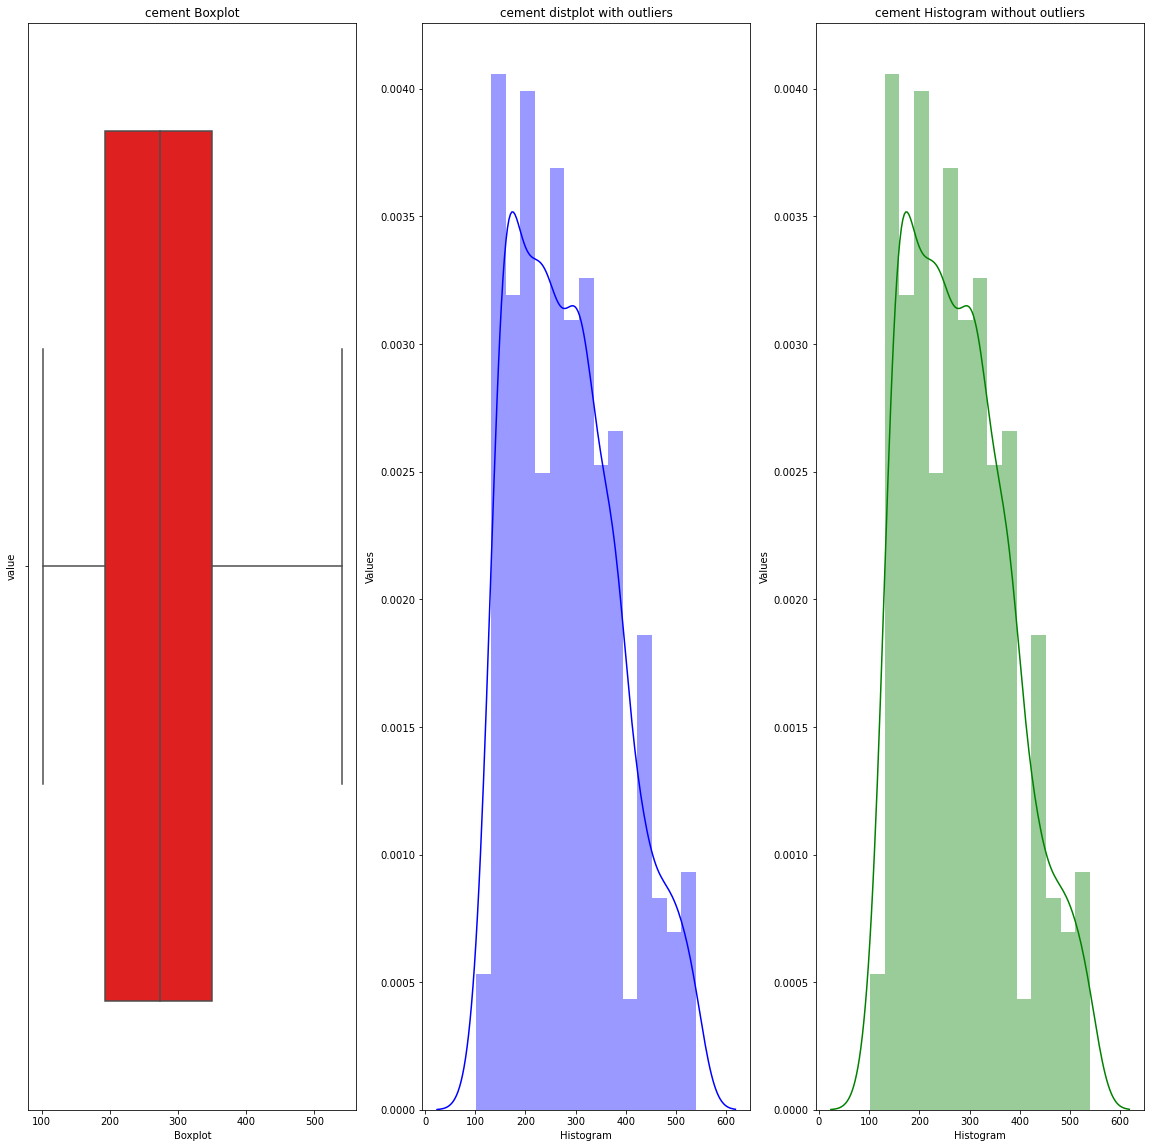

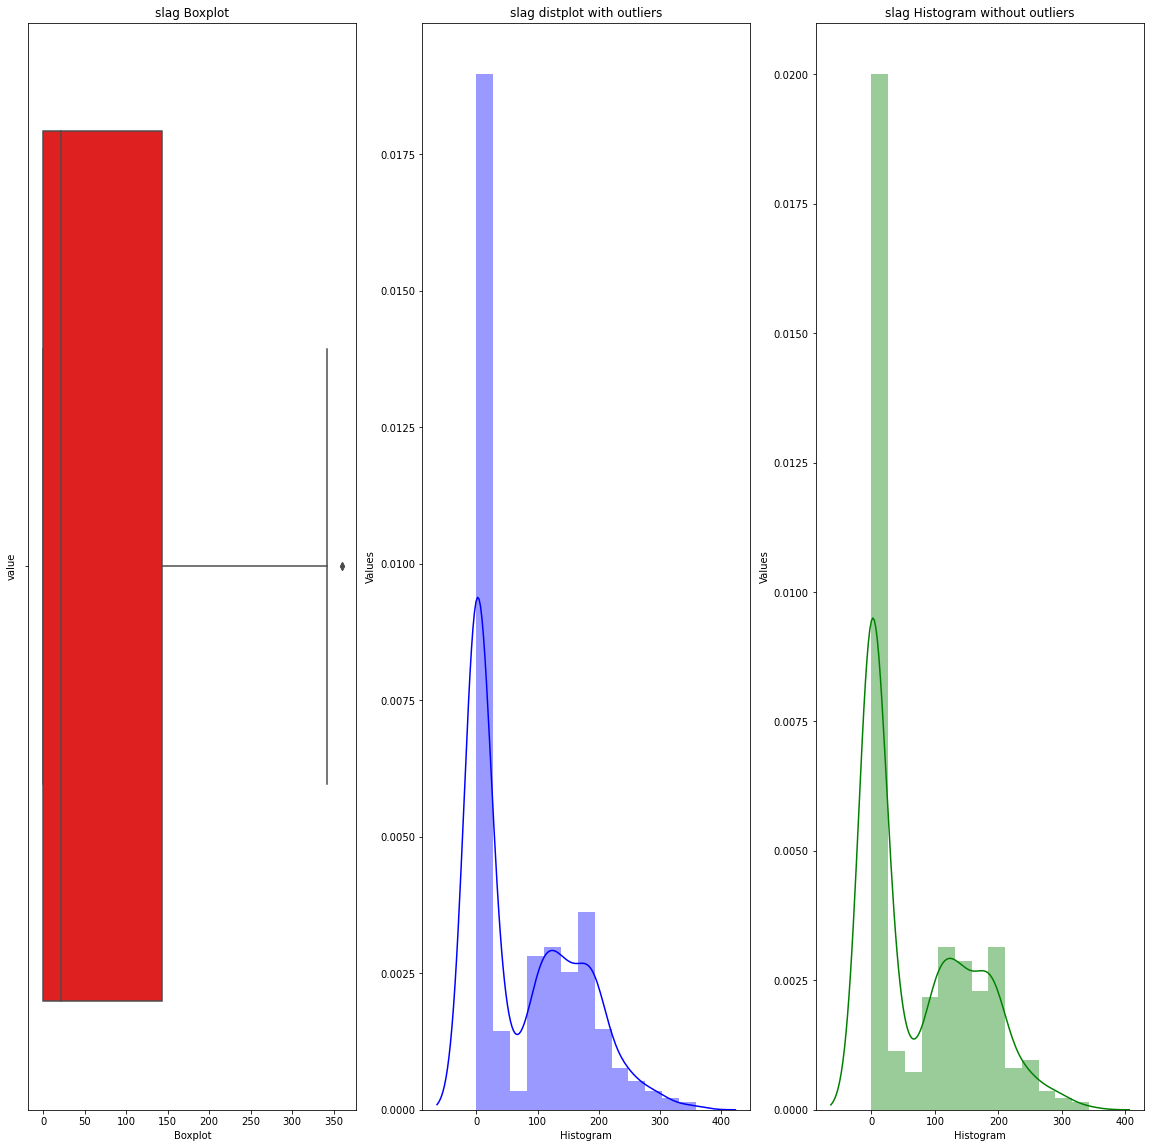

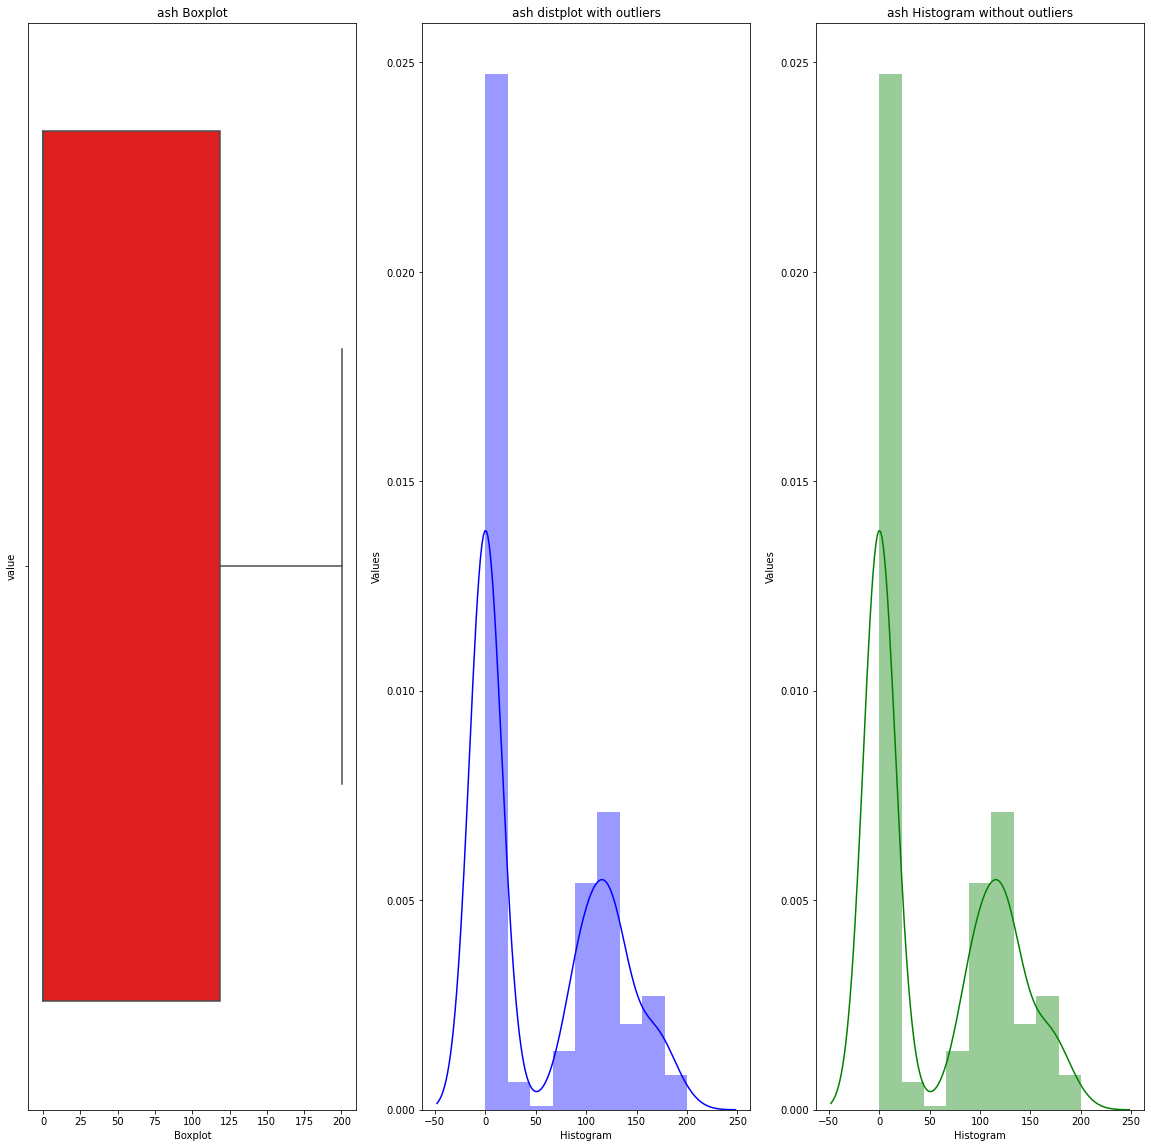

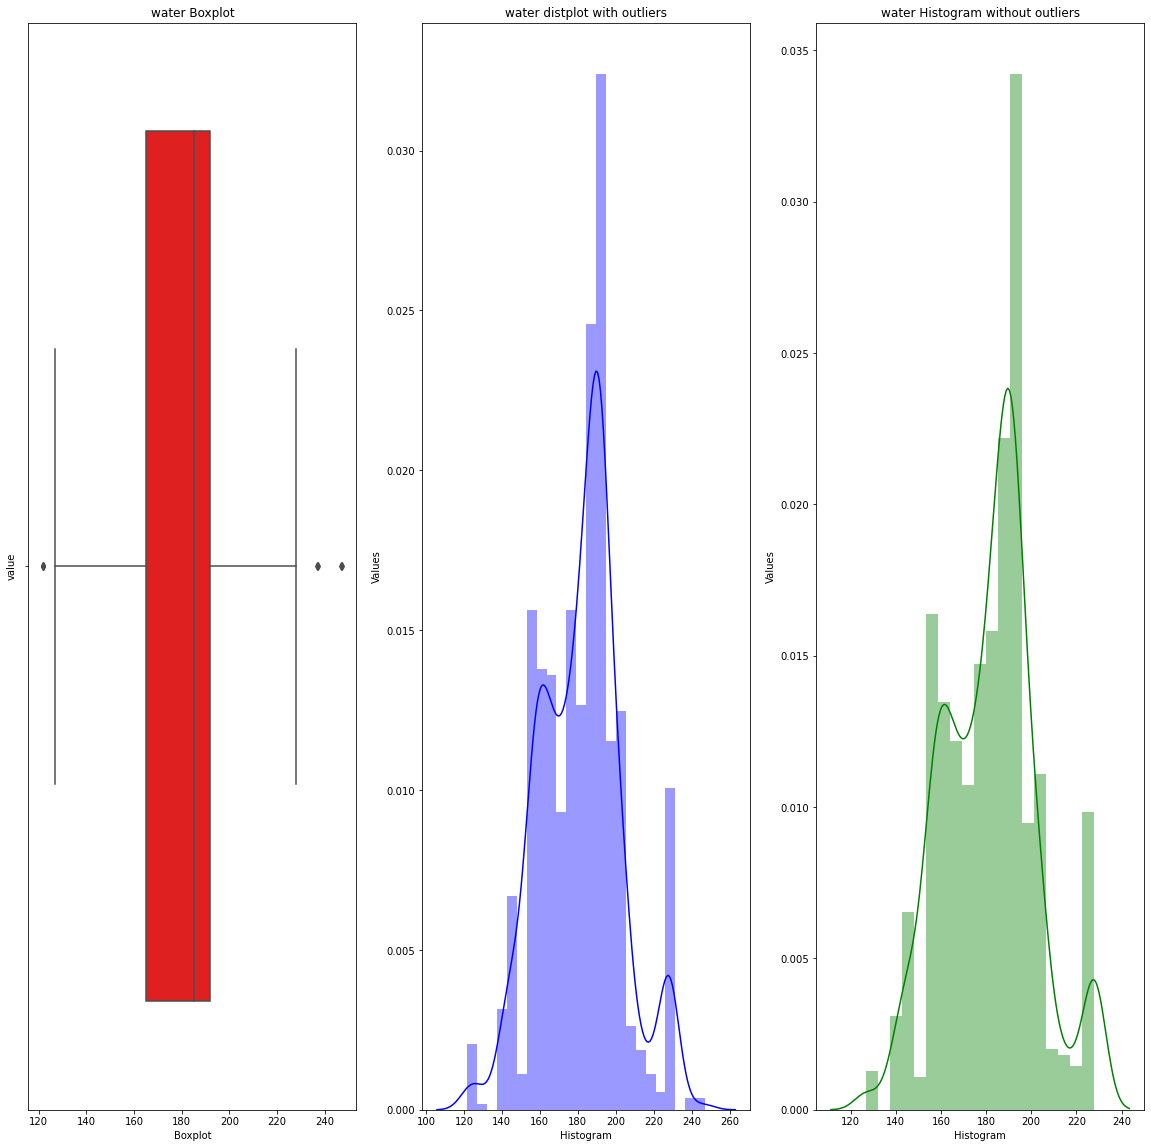

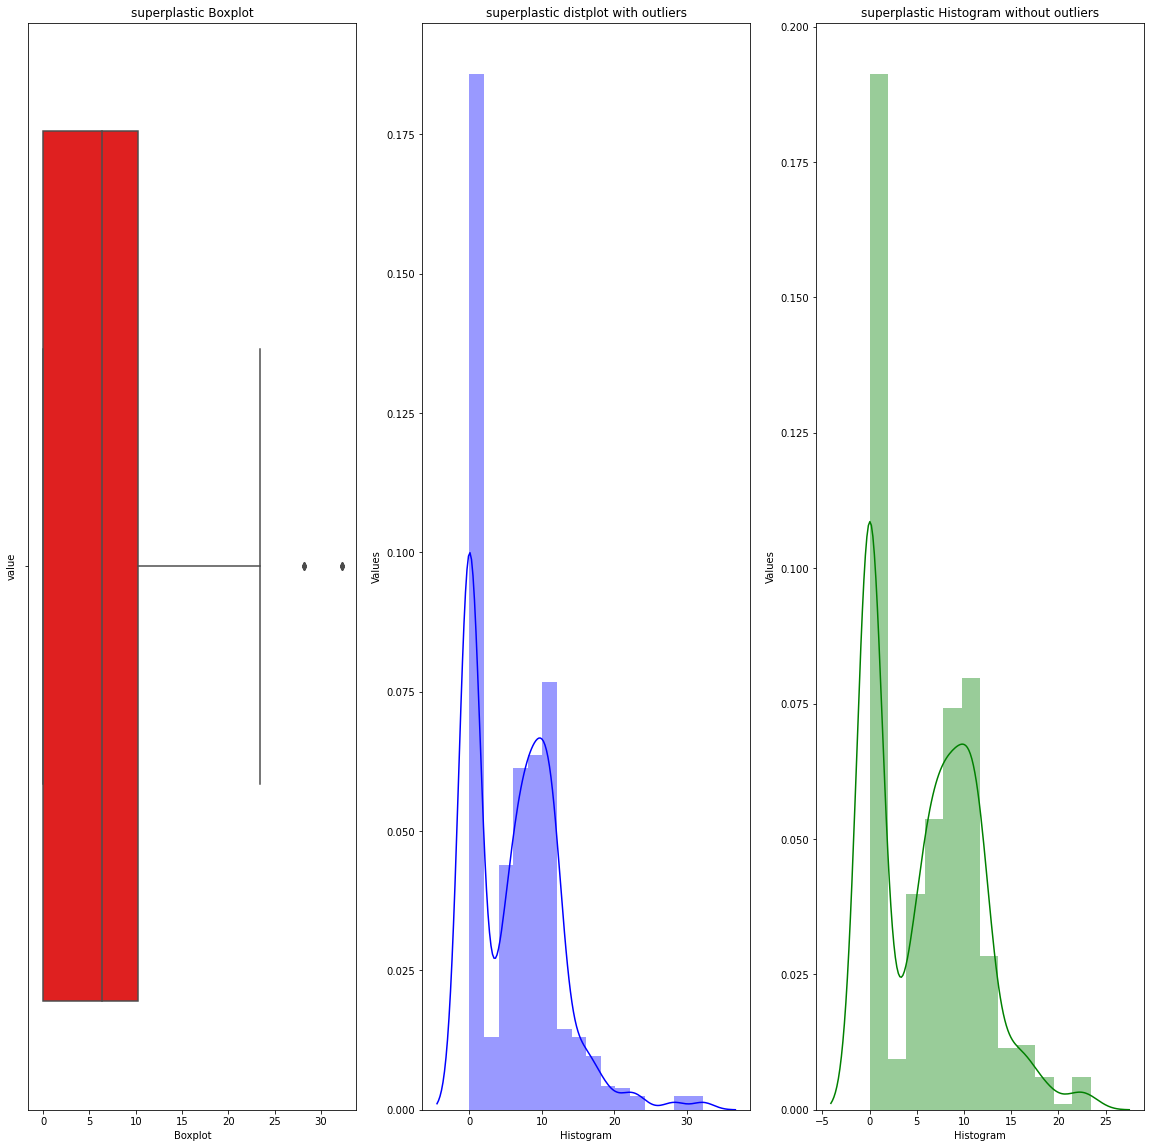

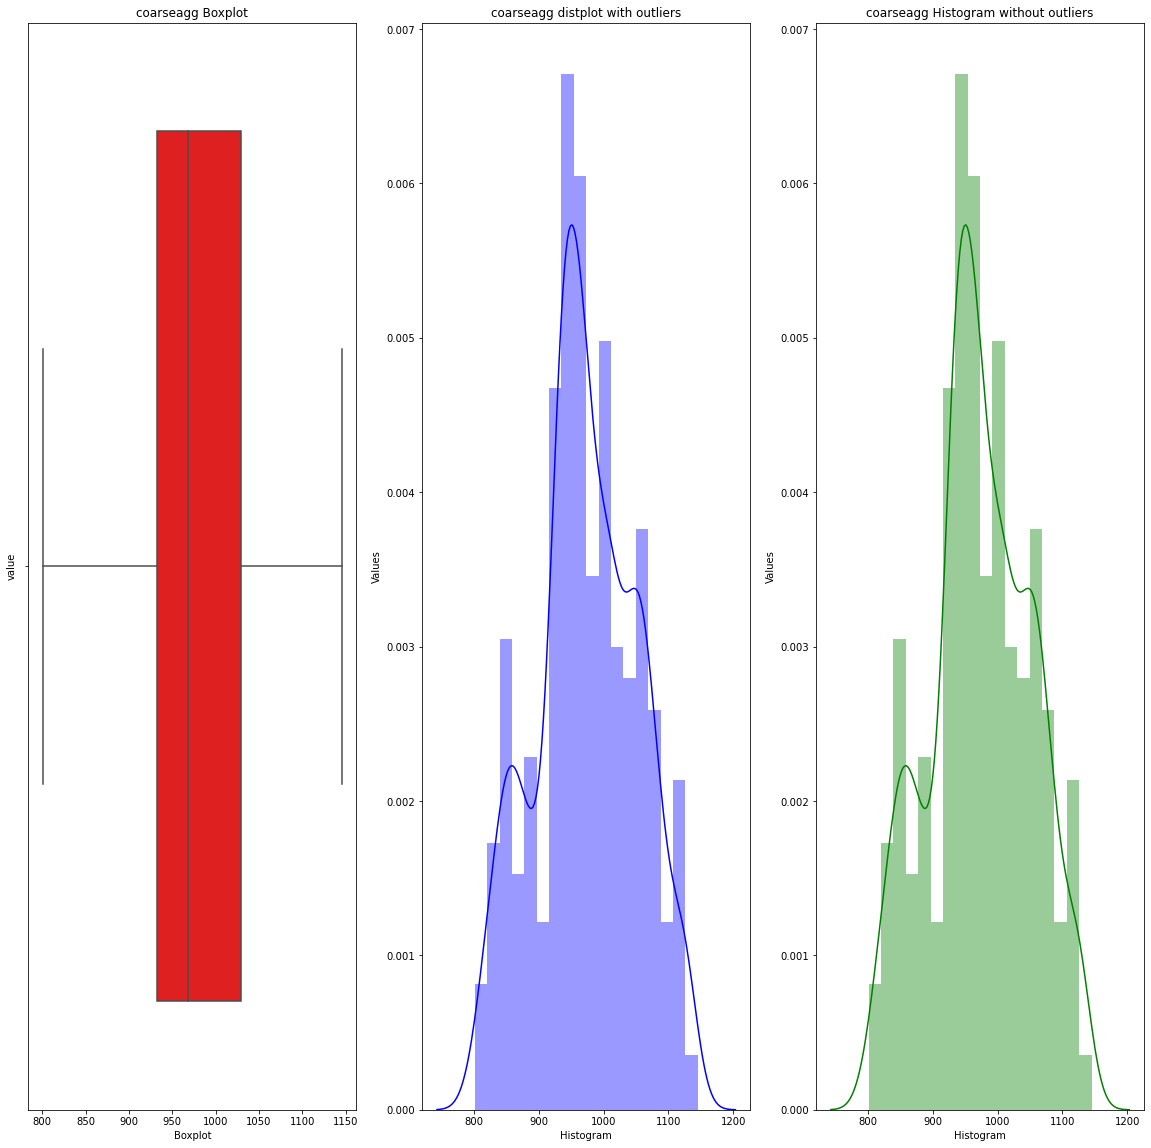

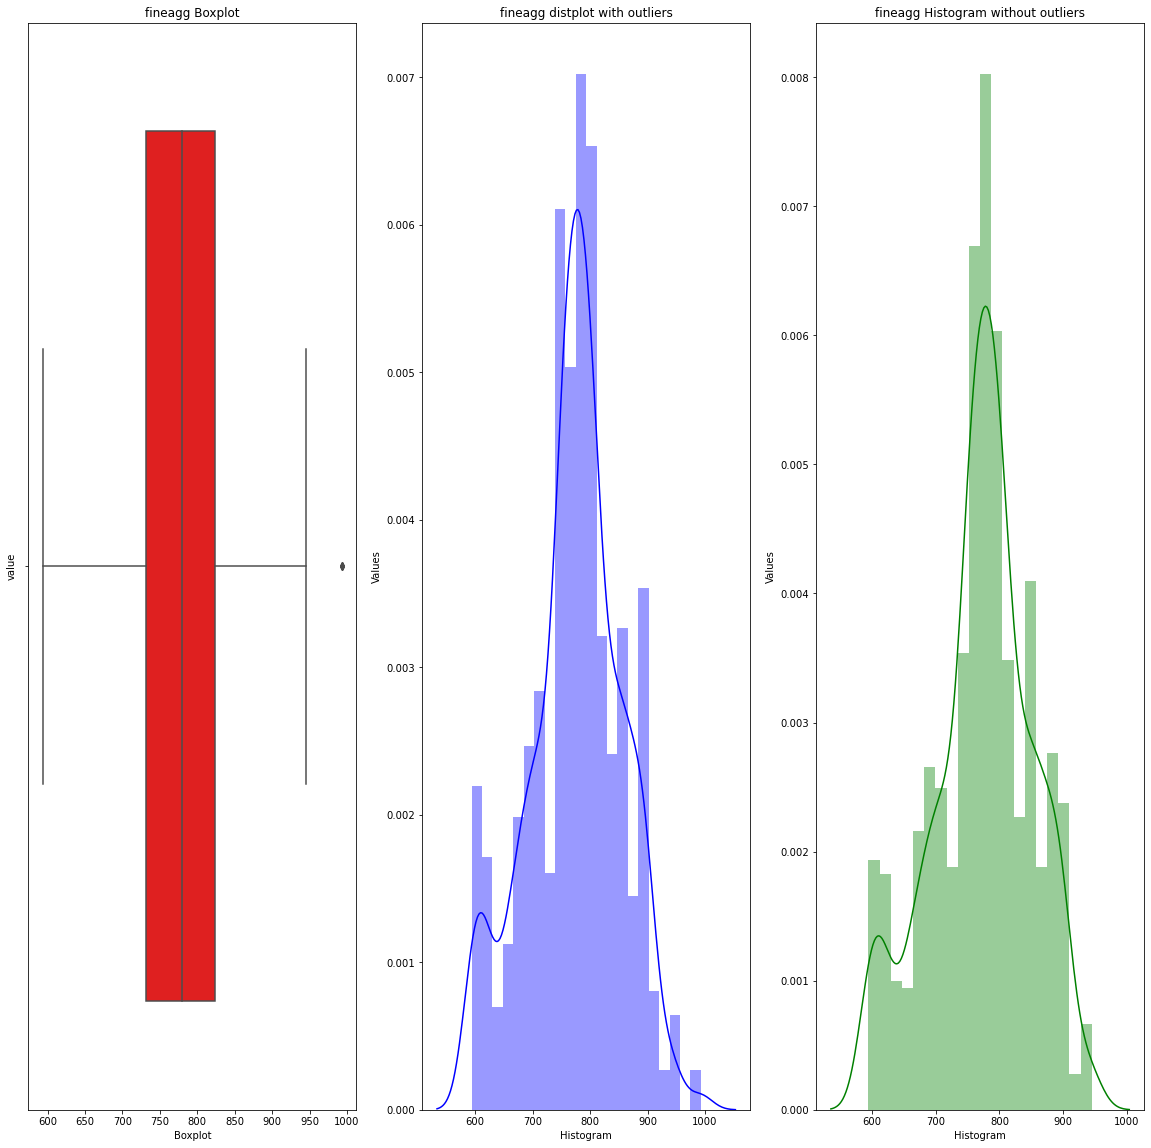

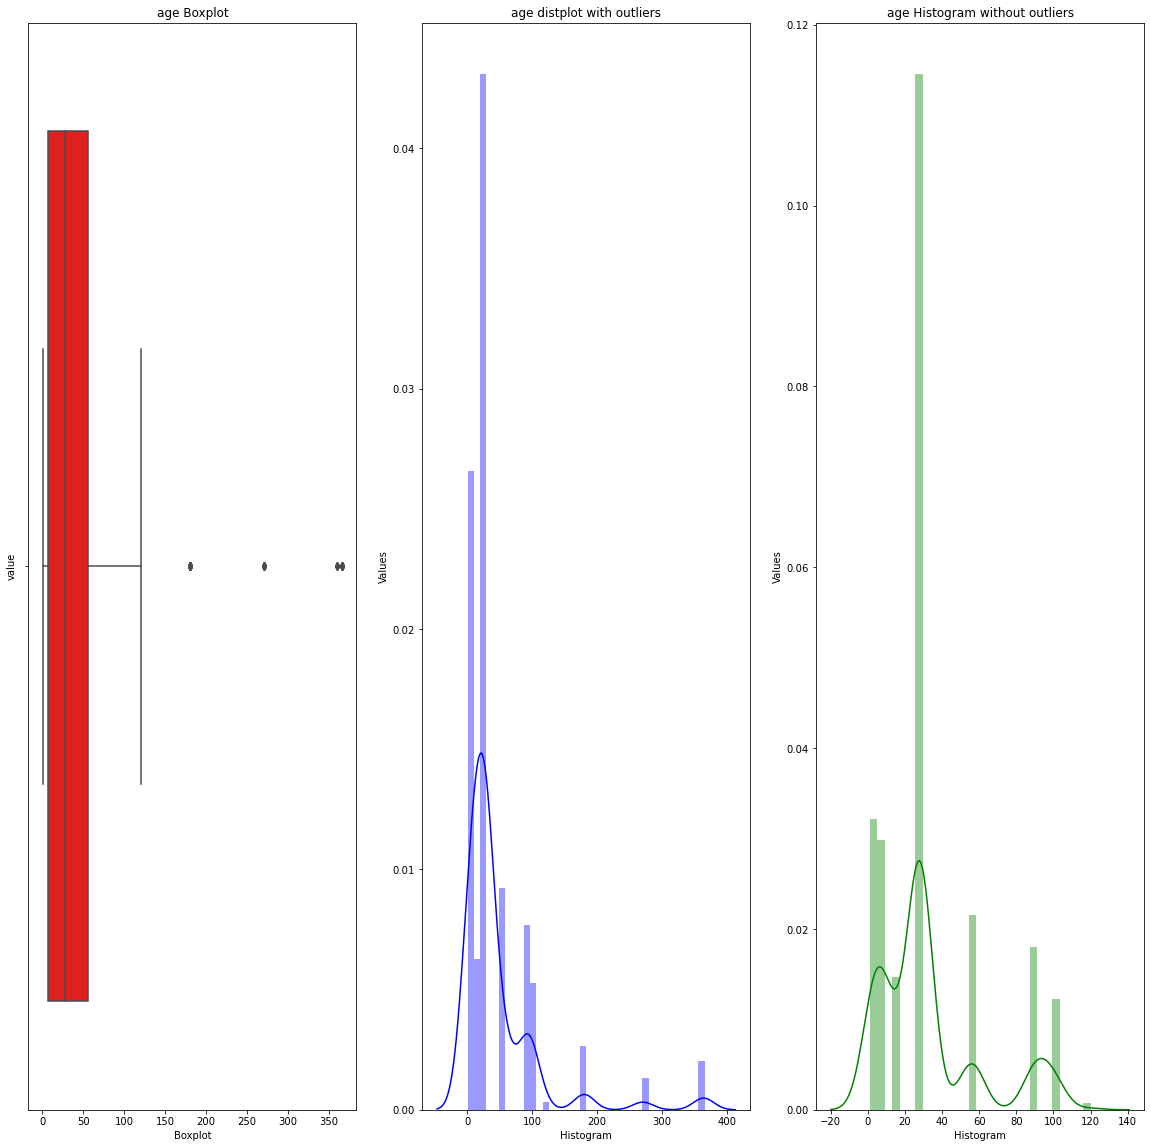

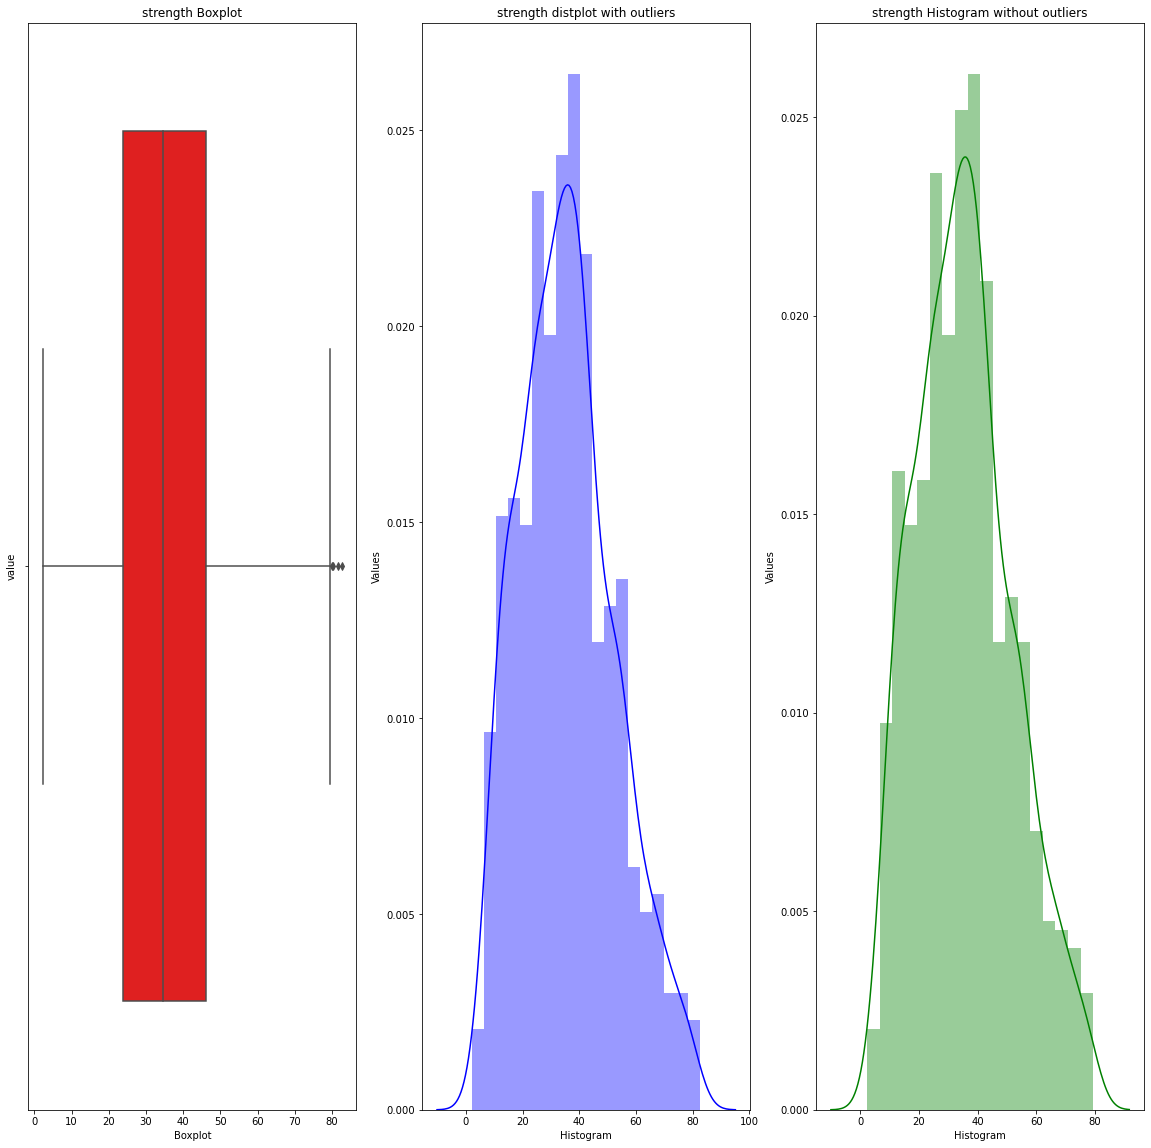

In [40]:
for col in df.columns:
    
    odt_plots(df,col)

### Multivariate analysis

1. We try to understand the relationship between each independent variable with the dependent variable

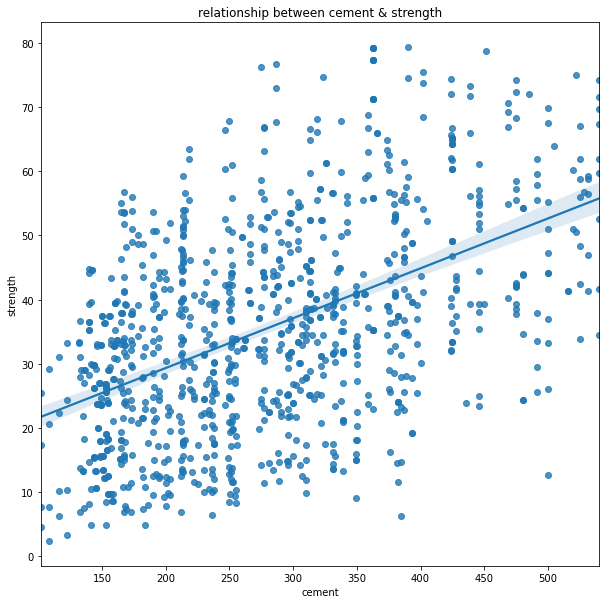

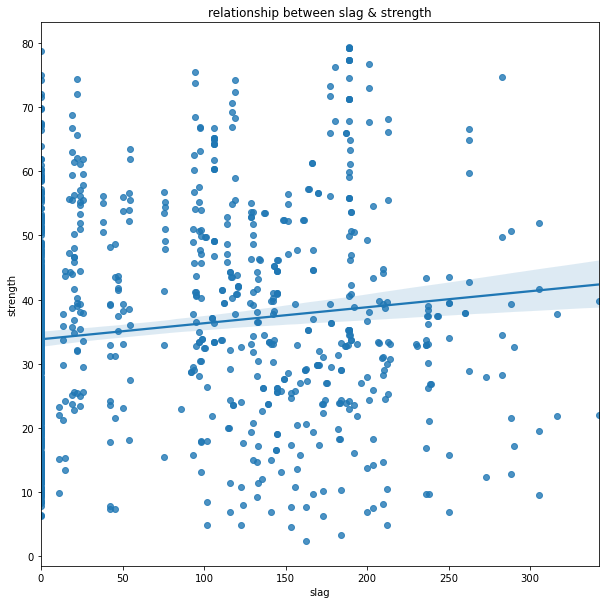

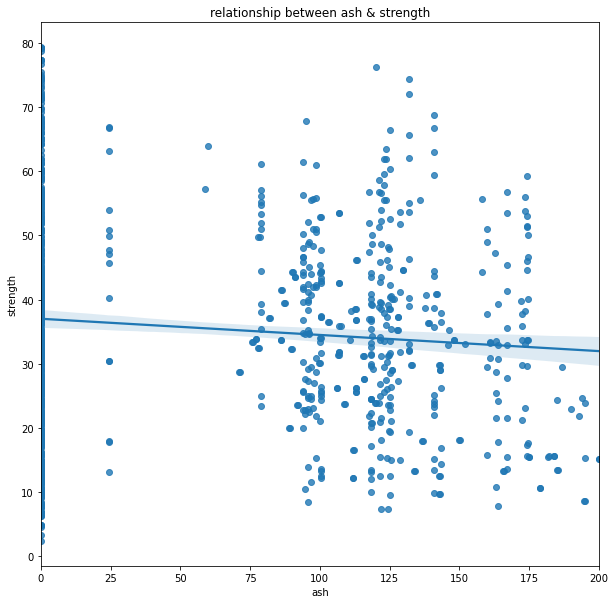

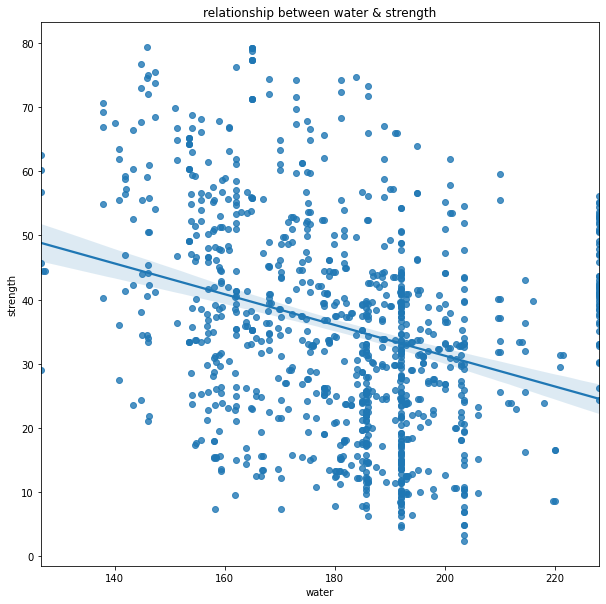

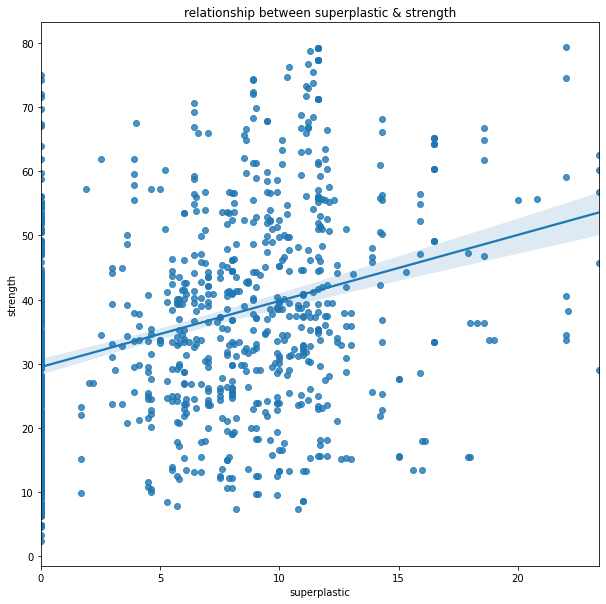

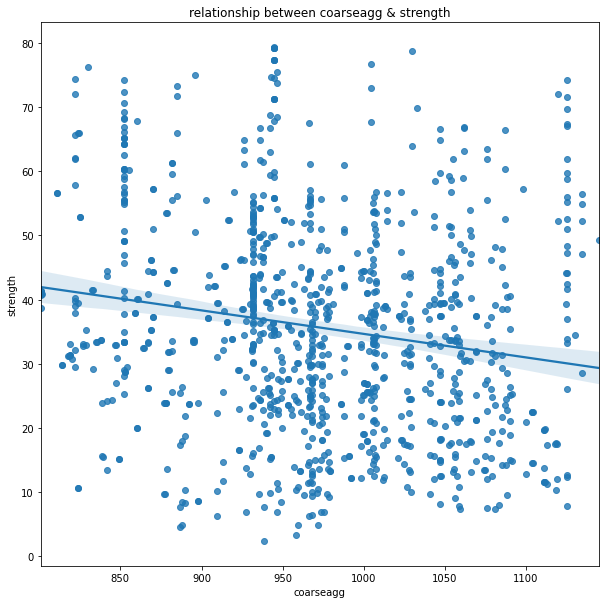

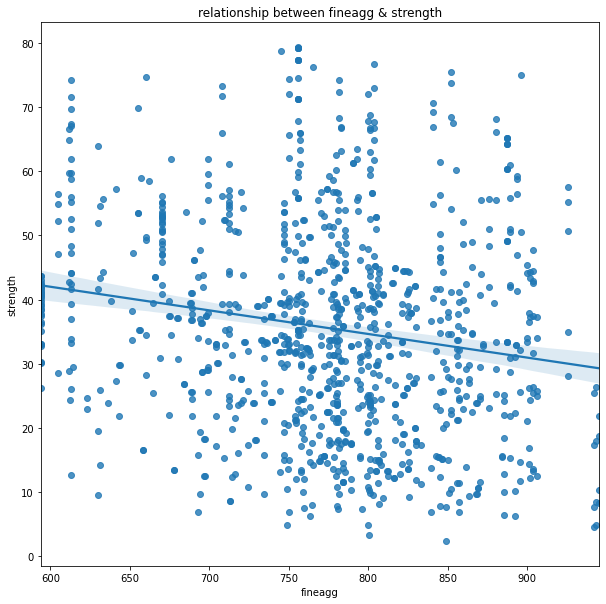

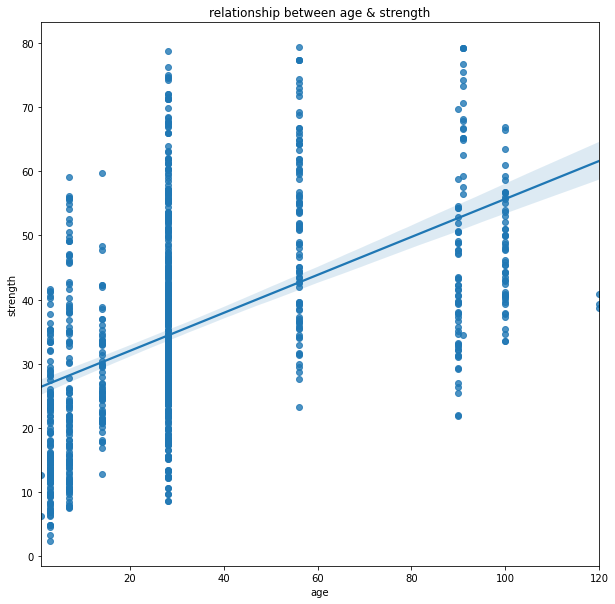

In [41]:
for col in df.columns:
    
    if col!='strength':
        
        f,ax1=plt.subplots(figsize=(10,10),sharex=False) # SHAREX-> Everything will be in a new row.
        sns.regplot(x=df[col],y=df['strength'],ax=ax1).set_title(f'relationship between {col} & strength')
        

### Multivariate analysis result

1. Positive correlation variables - cement,slag,superplastic,age
2. negative correlation variables - ash,water,coarseagg,fineagg

#### Finding the percentage of corelation between the feature and the target

In [42]:
def corr_target(df,target):
    ind_variable=df.drop([target],axis=1).columns
    
    corr_result=[]
    for col in ind_variable:
        corr_result.append(df[target].corr(df[col]))
    
    result_df=pd.DataFrame([ind_variable,corr_result],index=['features','correlation']).T
    
    return result_df.sort_values('correlation')

In [43]:
corr_target(df,'strength')

,features,correlation
3,water,-0.300043
6,fineagg,-0.176113
5,coarseagg,-0.173234
2,ash,-0.097973
1,slag,0.129561
4,superplastic,0.342633
0,cement,0.493518
7,age,0.499711


In [44]:
df_corr=df.corr()
df_corr

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
cement,1.000000,-0.275046,-0.397467,-0.091614,0.013336,-0.109349,-0.238698,-0.031962,0.493518
slag,-0.275046,1.000000,-0.320468,0.098880,0.061195,-0.283882,-0.282383,-0.028971,0.129561
ash,-0.397467,-0.320468,1.000000,-0.248011,0.447492,-0.009961,0.091729,0.057928,-0.097973
water,-0.091614,0.098880,-0.248011,1.000000,-0.658056,-0.156928,-0.426299,-0.040304,-0.300043
superplastic,0.013336,0.061195,0.447492,-0.658056,1.000000,-0.224503,0.156591,0.062013,0.342633
coarseagg,-0.109349,-0.283882,-0.009961,-0.156928,-0.224503,1.000000,-0.161377,0.018078,-0.173234
fineagg,-0.238698,-0.282383,0.091729,-0.426299,0.156591,-0.161377,1.000000,0.051532,-0.176113
age,-0.031962,-0.028971,0.057928,-0.040304,0.062013,0.018078,0.051532,1.000000,0.499711
strength,0.493518,0.129561,-0.097973,-0.300043,0.342633,-0.173234,-0.176113,0.499711,1.000000


<AxesSubplot:>

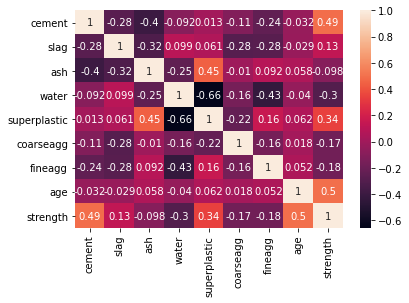

In [45]:
sns.heatmap(df_corr,annot=True)

#### Step1: Checking multicolinearity looking at the heat map

In [46]:
# ash-slag -> 32%
# cement-ash -> Negative 42%
# ash-superplastic -> 45%
# water-fineagg -> 43%
# superplastic-water -> 66%

In [47]:
## As we have conclude that above dataset has multicolinearity, applying PCA

## PCA

In [48]:
def apply_pca(x):
    
    n=len(x.columns)
    from sklearn.preprocessing import StandardScaler
    x=StandardScaler().fit_transform(x)
    
    from sklearn.decomposition import PCA
    
    for i in range(1,n):
        pca=PCA(n_components=i)
        p_components=pca.fit_transform(x)
        evr=np.cumsum(pca.explained_variance_ratio_) #evr->Explained variance ratio
        
        if evr[i-1] > 0.9 :
            n_components=i
            break
    
    print(evr)
    
    col=[]
    
    for j in range(1,n_components+1):
        col.append('pc_' + str(j))
    
    result=pd.DataFrame(data=p_components,columns=col)
    
    return result

In [49]:
transformed_df=apply_pca(df.drop(['strength'],axis=1))

[0.27112429 0.44666571 0.60914114 0.73584634 0.85926016 0.97264602]


In [50]:
transformed_df

,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6
0,1.810919,1.331664,-1.284484,-0.306148,-0.067652,-0.886110
1,-1.823833,-0.573436,-1.058973,0.893130,-0.913984,-0.751061
2,-0.739819,-0.463200,-0.541643,-1.033210,-0.308068,0.611045
3,2.766368,0.602978,-0.512532,0.008806,0.086415,0.850548
4,0.892523,0.966627,-0.863624,1.148561,-0.064439,-1.221228
...,...,...,...,...,...,...
1025,-1.743036,0.071059,-1.492203,0.045227,-0.449481,0.968953
1026,-1.079147,-0.572265,3.269799,-1.669125,-0.962953,0.002303
1027,-0.494143,1.276989,0.318398,-0.053272,-0.153787,0.751019
1028,2.688411,-0.236744,0.056551,-0.088955,0.105206,1.368321


In [51]:
transformed_df=transformed_df.join(df['strength'],how='left')

In [52]:
transformed_df

,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6,strength
0,1.810919,1.331664,-1.284484,-0.306148,-0.067652,-0.886110,29.89
1,-1.823833,-0.573436,-1.058973,0.893130,-0.913984,-0.751061,23.51
2,-0.739819,-0.463200,-0.541643,-1.033210,-0.308068,0.611045,29.22
3,2.766368,0.602978,-0.512532,0.008806,0.086415,0.850548,45.85
4,0.892523,0.966627,-0.863624,1.148561,-0.064439,-1.221228,18.29
...,...,...,...,...,...,...,...
1025,-1.743036,0.071059,-1.492203,0.045227,-0.449481,0.968953,13.29
1026,-1.079147,-0.572265,3.269799,-1.669125,-0.962953,0.002303,41.30
1027,-0.494143,1.276989,0.318398,-0.053272,-0.153787,0.751019,44.28
1028,2.688411,-0.236744,0.056551,-0.088955,0.105206,1.368321,55.06


## Model Building

### Train test split

In [53]:
def train_and_test_split(df,target,test_size=0.3):
    x=df.drop(target,axis=1)
    y=df[[target]]
    return train_test_split(x,y,test_size=test_size,random_state=43)

In [59]:
def build_model(model_name,model,df,target):
    
    x_train,x_test,y_train,y_test=train_and_test_split(df,target)
    model.fit(x_train,y_train)
    model_pred=model.predict(x_test)
    rmse=np.sqrt(mean_squared_error(y_test,model_pred))
    r2score=r2_score(y_test,model_pred)
    temp=[model_name,rmse,r2score]
    return temp

In [60]:
print(build_model('Linear_Regression',LinearRegression(),transformed_df,'strength'))

['Linear_Regression', 9.50162131324983, 0.6589541977232001]


In [61]:
def build_multiple_models(df,target):
    
    col_names=['model_name','rmse','r2score']
    result=pd.DataFrame(columns=col_names)
    result.loc[len(result)]=build_model('Linear_Regression',LinearRegression(),df,target)
    result.loc[len(result)]=build_model('Decision_tree',DecisionTreeRegressor(),df,target)
    result.loc[len(result)]=build_model('Random_forest',RandomForestRegressor(),df,target)
    result.loc[len(result)]=build_model('XG_boost',XGBRegressor(),df,target)
    return result

In [62]:
build_multiple_models(transformed_df,'strength')

,model_name,rmse,r2score
0,Linear_Regression,9.501621,0.658954
1,Decision_tree,8.666576,0.716265
2,Random_forest,6.277446,0.851138
3,XG_boost,6.102682,0.859311


So as the XGboost gives us a higher accuracy and low rmse...we can Conclude that Xgboost is the best model

(Random Forest is also good)

###  Cross Validation

In [65]:
def k_foldcv(df,target,fold=10):
    x=df.drop('strength',axis=1)
    y=df[[target]]
    
    
    score_lr=cross_val_score(LinearRegression(),x,y,cv=fold)
    score_DTR=cross_val_score(DecisionTreeRegressor(),x,y,cv=fold)
    score_RF=cross_val_score(RandomForestRegressor(),x,y,cv=fold)
    score_xgb=cross_val_score(XGBRegressor(),x,y,cv=fold)
    
    scores=[score_lr,score_DTR,score_RF,score_xgb]
    names=['Linear_Regression','Decision_tree','Random_forest','XG_boost']
    
    result=[]
    for i in range(0,len(scores)):
        score=np.mean(scores[i])
        std=np.std(scores[i])
        temp=[names[i],score,std]
        result.append(temp)
        
    result_df=pd.DataFrame(result,columns=['model_name','r2score','standard_deviation'])
    return result_df
    

In [66]:
k_foldcv(transformed_df,'strength')

,model_name,r2score,standard_deviation
0,Linear_Regression,0.663928,0.059476
1,Decision_tree,0.758289,0.061064
2,Random_forest,0.867006,0.032582
3,XG_boost,0.873262,0.036061


XG_Boost and Random_Forest are good models...as their r2score is higher... and also std_dev is low.


###  Hyperparameter Tuning

In [67]:
def hyper_param(df,target,fold=10):
    x=df.drop(target,axis=1)
    y=df[[target]]
    
    
    param_rf={'n_estimators':[10,20,30,40,50]}
    param_xg={'alpha':[0,0.1,0,2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],'gamma':[10,30,40,70,100]}
    

    tunned_rf=GridSearchCV(estimator=RandomForestRegressor(),param_grid=param_rf,cv=fold)
    tunned_xg=GridSearchCV(estimator=XGBRegressor(),param_grid=param_xg,cv=fold)
    
    
    
    tunned_rf.fit(x,y)
    tunned_xg.fit(x,y)
    
    tunned=[tunned_rf,tunned_xg]
    names=['Random_forest','XG_Boost']
    
    for i in range(0,len(tunned)):
        print('Model',names[i])
        print('Best_parameters',tunned[i].best_params_)

In [68]:
hyper_param(transformed_df,'strength')

Model Random_forest
Best_parameters {'n_estimators': 50}
Model XG_Boost
Best_parameters {'alpha': 0.6, 'gamma': 10}


In [69]:
# Cross validation

def k_foldcv_tunned(df,target,fold=10):
    x=df.drop('strength',axis=1)
    y=df[[target]]
    
    
    score_lr=cross_val_score(LinearRegression(),x,y,cv=fold)
    score_dtr=cross_val_score(DecisionTreeRegressor(),x,y,cv=fold)
    score_rf=cross_val_score(RandomForestRegressor(n_estimators=40),x,y,cv=fold)
    score_xgb=cross_val_score(XGBRegressor(alpha= 0.6, gamma=10),x,y,cv=fold)

    
    scores=[score_lr,score_dtr,score_rf,score_xgb]
    names=['Linear_Regression','Decision_tree','Random_forest','XG_boost']
    
    result=[]
    for i in range(0,len(scores)):
        score=np.mean(scores[i])
        std=np.std(scores[i])
        temp=[names[i],score,std]
        result.append(temp)
        
    result_df=pd.DataFrame(result,columns=['model_name','r2score','standard_deviation'])
    return result_df
    

In [70]:
k_foldcv_tunned(transformed_df,'strength')

,model_name,r2score,standard_deviation
0,Linear_Regression,0.663928,0.059476
1,Decision_tree,0.764146,0.059427
2,Random_forest,0.866197,0.029355
3,XG_boost,0.869284,0.033411


The models Xgboost and RF can be considered as the best models as their r2score is highest. and Std_dev is also low.